In [67]:
# Imports
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

warnings.filterwarnings("ignore")
warnings.showwarning = False

In [62]:
# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large', titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
train = image_dataset_from_directory('animal_data', labels='inferred', label_mode='categorical', subset='training', 
                                      validation_split=0.1, image_size=[128, 128], interpolation='nearest', 
                                      batch_size=64, shuffle=True, seed=0)
valid = image_dataset_from_directory('animal_data', labels='inferred', label_mode='categorical', subset='validation', 
                                     validation_split=0.1, image_size=[128, 128], interpolation='nearest', 
                                     batch_size=64, shuffle=True, seed=0)
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

Found 1944 files belonging to 15 classes.
Using 1750 files for training.
Found 1944 files belonging to 15 classes.
Using 194 files for validation.


In [63]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train = (train.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE))
valid = (valid.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE))

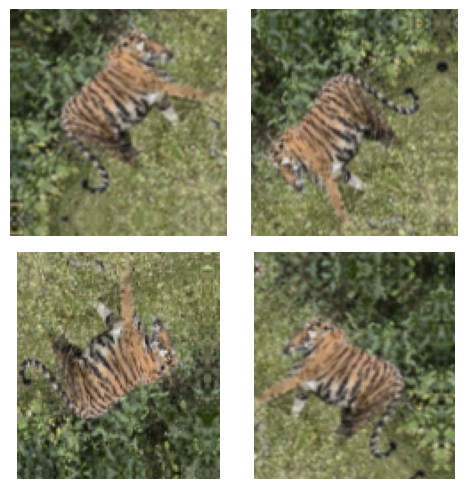

In [64]:
# all of the "factor" parameters indicate a percent-change
augment = keras.Sequential([
    #preprocessing.RandomContrast(factor=0.5),
    preprocessing.RandomFlip(mode='horizontal'), # meaning, left-to-right
    preprocessing.RandomFlip(mode='vertical'), # meaning, top-to-bottom
    preprocessing.RandomWidth(factor=0.15), # horizontal stretch
    preprocessing.RandomRotation(factor=0.20),
    preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1)])

ex = next(iter(train.unbatch().map(lambda x, y: x).batch(1)))

plt.figure(figsize=(5,5))
for i in range(4):
    image = augment(ex, training=True)
    plt.subplot(2, 2, i+1)
    plt.imshow(tf.squeeze(image))
    plt.axis('off')
plt.show()

In [68]:
# Load VGG16
pretrained_base = tf.keras.models.load_model('../Pretrained CNNs/cv-course-models/vgg16-pretrained-base', compile=False)

model = keras.Sequential([pretrained_base, layers.Flatten(), layers.Dense(6, activation='relu'),
    layers.Dense(15, activation='sigmoid')])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [69]:
history = model.fit(train, validation_data=valid, epochs = 1)

28/28 [==============================] - 156s 6s/step - loss: 2.9280 - categorical_accuracy: 0.0623 - val_loss: 2.7085 - val_categorical_accuracy: 0.0464


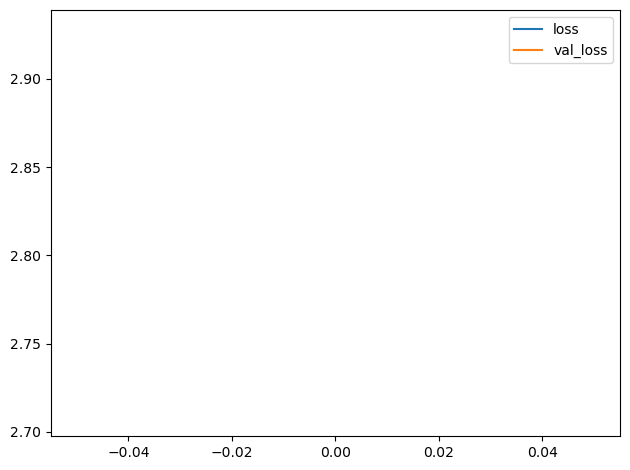

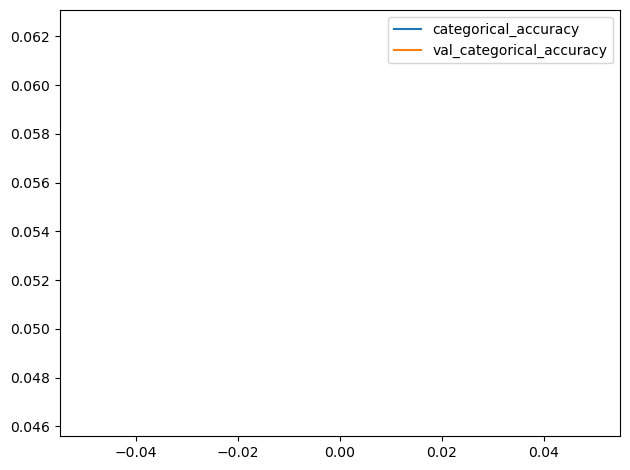

In [70]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot();

In [71]:
model = keras.Sequential([
    layers.InputLayer(input_shape=[128, 128, 3]),
    
    # Data Augmentation
    preprocessing.RandomContrast(factor=1),
    preprocessing.RandomFlip(mode = 'horizontal'),
    preprocessing.RandomFlip(mode = 'vertical'),
    preprocessing.RandomRotation(factor = 0.10),

    # Block One
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(15, activation='sigmoid')])


In [72]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history = model.fit(train, validation_data=valid, epochs=15)

Epoch 1/15
28/28 [==============================] - 45s 2s/step - loss: 2.7081 - categorical_accuracy: 0.0600 - val_loss: 2.7076 - val_categorical_accuracy: 0.0464
Epoch 2/15
28/28 [==============================] - 47s 2s/step - loss: 2.7067 - categorical_accuracy: 0.0789 - val_loss: 2.7026 - val_categorical_accuracy: 0.0464
Epoch 3/15
28/28 [==============================] - 46s 2s/step - loss: 2.6932 - categorical_accuracy: 0.0886 - val_loss: 2.6689 - val_categorical_accuracy: 0.0515
Epoch 4/15
28/28 [==============================] - 45s 2s/step - loss: 2.6748 - categorical_accuracy: 0.0663 - val_loss: 2.6741 - val_categorical_accuracy: 0.0515
Epoch 5/15
28/28 [==============================] - 45s 2s/step - loss: 2.6888 - categorical_accuracy: 0.0897 - val_loss: 2.6662 - val_categorical_accuracy: 0.0670
Epoch 6/15
28/28 [==============================] - 45s 2s/step - loss: 2.7092 - categorical_accuracy: 0.0829 - val_loss: 2.6111 - val_categorical_accuracy: 0.0928
Epoch 7/15
28/28

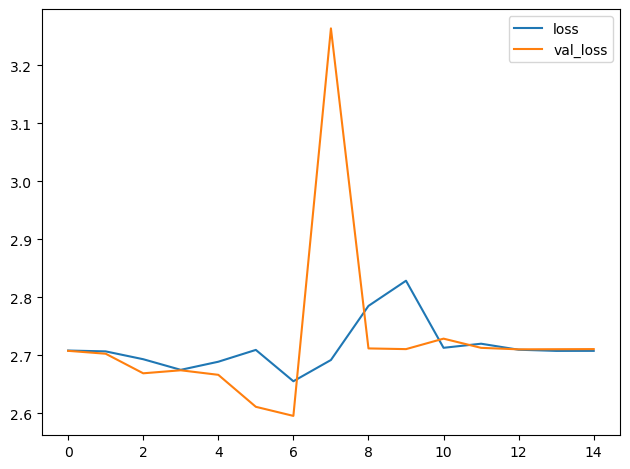

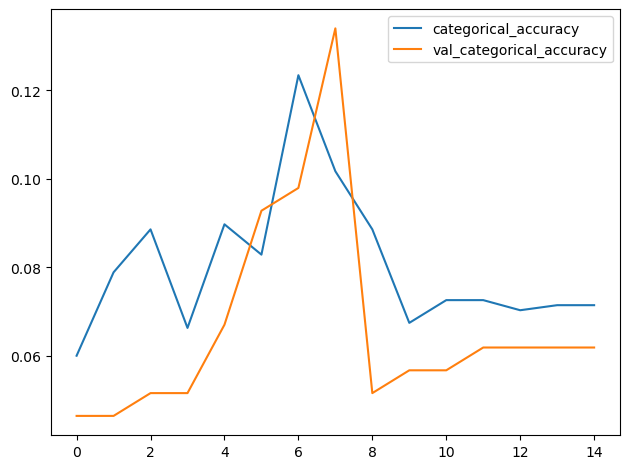

In [74]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot();